In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

In [2]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, shuffle=False)

In [0]:
# Definir a arquitetura MLP

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        #self.norm = nn.BatchNorm2d(18)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(18*16*16, 64)
        self.drop = nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(64, 10)
        self.activation_function = nn.ReLU()
      
    def forward(self, x):
        x = self.activation_function(self.conv1(x))
        #x = self.norm(x)
        x = self.pool1(x)
        x = x.view(-1, 18*16*16)
        x = self.activation_function(self.fc1(x))
        x = self.drop(x)
        x = self.activation_function(self.fc2(x))
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN()
model.to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (drop): Dropout(p=0.6)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (activation_function): ReLU()
)


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
losses = []
accuracies = []
for epoch in range(30):
    correct = 0
    total = 0
    loss_media = 0
    model.train()
    tempo_inicial = time.time()
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        if(i < 35000):
            optimizer.zero_grad()
     
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        else:
            model.eval()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss_media += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).sum().item()
            total += 1
    loss_media = loss_media / total
    losses.append(loss_media)        
    tempo = time.time() - tempo_inicial
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print('Acurácia na epoca {} é {:.2f}%, loss = {:.2f} e tempo = {:.2f}s'.format(epoch+1, accuracy, loss_media, tempo))
        
print('Acurácia total no validation: {:.2f}%'.format(100 * correct / total))


Acurácia na epoca 1 é 45.61%, loss = 1.56 e tempo = 63.20s
Acurácia na epoca 2 é 48.92%, loss = 1.47 e tempo = 63.17s
Acurácia na epoca 3 é 49.35%, loss = 1.47 e tempo = 62.27s
Acurácia na epoca 4 é 49.23%, loss = 1.44 e tempo = 63.58s
Acurácia na epoca 5 é 50.07%, loss = 1.42 e tempo = 64.98s
Acurácia na epoca 6 é 52.68%, loss = 1.37 e tempo = 63.22s
Acurácia na epoca 7 é 53.13%, loss = 1.36 e tempo = 63.12s
Acurácia na epoca 8 é 54.42%, loss = 1.31 e tempo = 62.00s
Acurácia na epoca 9 é 54.28%, loss = 1.32 e tempo = 63.85s
Acurácia na epoca 10 é 55.17%, loss = 1.30 e tempo = 64.66s
Acurácia na epoca 11 é 56.32%, loss = 1.24 e tempo = 63.11s
Acurácia na epoca 12 é 56.76%, loss = 1.27 e tempo = 62.26s
Acurácia na epoca 13 é 57.47%, loss = 1.25 e tempo = 62.59s
Acurácia na epoca 14 é 58.07%, loss = 1.21 e tempo = 63.95s
Acurácia na epoca 15 é 59.11%, loss = 1.21 e tempo = 64.82s
Acurácia na epoca 16 é 60.58%, loss = 1.17 e tempo = 63.17s
Acurácia na epoca 17 é 59.36%, loss = 1.16 e temp

In [11]:
correct = 0
total = 0
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()

print('Acurácia total no test: {:.2f}%'.format(100 * correct / total))

Acurácia total no test: 58.19%


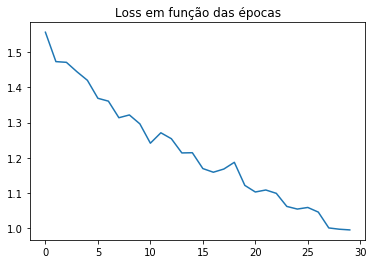

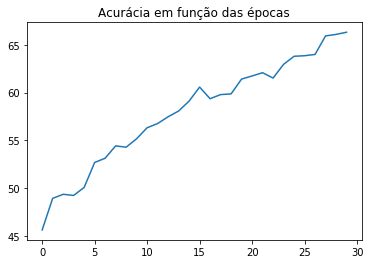

In [12]:
plt.title("Loss em função das épocas")
plt.plot(losses)
plt.show()

plt.title("Acurácia em função das épocas")
plt.plot(accuracies)
plt.show()

# Considerações
-Por falta de tempo, não consegui testar pra RGB e brincar com mais camadas convolucionais

-Mini Batch se mostrou menos eficiente em comparação com Estocástico

-Pela tendecia observada na curva de loss e accuracy, com mais épocas o resultado tende a aumentar

-Batch Norm atrasou significativamente o processo de treinamento, e ao meu ver, não compensou em porcentagem. Por isso, optei por não utilizar.

-Dropout se mostrou necessário, aumentando em média 5% de accuracy.

